# 1. Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cdlib import viz
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
#from pyvis import network as net
from cdlib import algorithms, viz
from difflib import get_close_matches
from collections import Counter
from difflib import SequenceMatcher
import pandas_profiling

Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'leidenalg', 'graph_tool', 'wurlitzer', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


## 1.1 Importing data

In [4]:
# load data from tsv file to a pandas dataframe
movies_metadata = pd.read_csv(
    'MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
character_metadata = pd.read_csv(
    'MovieSummaries/character.metadata.tsv', sep='\t', header=None)
plot_summaries = pd.read_csv(
    'MovieSummaries/plot_summaries.txt', sep='\t', header=None)



The columns have the following labels (extracted from Pandaprofiling reports and our analysis):

Movie metadata:

| Column | Type of data  | Missing values    | Summary   |
|---:|:-------------|:-----------|:------|
| Wikipedia movie ID | Integer unique  | 0       | Unique Wikipedia IDs to identify movies  |
| Freebase movie ID | Categorical unique  | 0    | Unique identifiers for movies in the Freebase database.  |
| Movie name | Categorical  | 0       | Movie name in original language   | 
| Movie release date | Categorical  | 6902 / 8.4%    | Date of release of the movie , can be in different formats and contains some missing values   |
| Movie box office revenue | Real number  | 73340 / 89.7%       | Income from ticket sales of the movie . Too many missing values , this column cannot be used . It is also not ideal to replace these values from other data sources since a large portion of the movies of our dataset don't figure in the box office at all . A good idea would be to replace this column with another score metric ( like IMDB ratings ) if needed in P3   |
| Movie runtime | Real number  | 20450 / 25.0%    | Length of the movie in minutes . Important amount of missing values but this column won't be needed in our analysis   |
| Movie languages | Categorical  | 13866 / 17.0%       | Original language of the movie . Represented in dictionary format with each language and its associated Freebase ID . Contains A few missing values .  |
| Movie countries | Categorical  | 8154 / 10.0%    | Country where the movie was released . Represented in dictionary format with each country and its associated Freebase ID . Some missing values but we don't use this column yet . An interesting idea for the next milestone would be to compare communities country distribution with the movie country   |
| Movie genres | Categorical | 2294 / 2.8%      | Genre of the movie . Represented in dictionary format with each genre and its associated Freebase ID . Few missing values but we don't use this column yet . This label can be useful to test hypothesis involving communities  |

Character metadata:

| Column | Type of data  | Missing values    | Summary   |
|---:|:-------------|:-----------|:------|
| Wikipedia movie ID | Integer   | 0       | Wikipedia ID of the movie where a character is portrayed  |
| Freebase movie ID | Categorical unique  | 0    | Identifiers for movies in the Freebase database a character is portrayed  |
| Movie release date | Categorical  | 9995 / 2.2%    | Date of release of the movie , can be in different formats and contains some missing values   |
| Character name | Categorical  | 257875 / 57.2%       | Name of character portrayed . Contains a lot of missing values and won't be used in our analysis  |
| Actor date of birth | Categorical  | 106145 / 23.6%    | Date of birth of the concerned actor . Significant amount of missing values which we will be filling later after communties are established ( explained below ). The actor date of birth is converted to actor age  |
| Actor gender | Categorical  | 45609 / 10.1%       | Gender of the actor , either "M" or "F" . Missing values are replaced using queries from Wikidata  |
| Actor height | Real number  | 295845 / 65.6%    | Height of the actor in meters . A lot of missing and skewed values but we won't use this column in our analysis. |
| Actor ethnicity  | Categorical | 344611 / 76.5%      | Freebase ID of the ethnicity of the actor . Very interesting feature that would have contributed a lot in our analysis but too many missing values and no way of replacing them . Will be replaced with country of citizenship of the actor after querying from Wikidata   |
| Actor name | Categorical  | 1228 / 0.3%    | Name of the actor . Contains some duplicates since some actors have the same name , therefore can't be used reliably to identify specific actors  |
| Actor age at movie release | Real number  | 158113 / 35.1%       | Age of the actor when the movie was released . Contains a lot of missing and skewed values but we won't use this column in our analysis |
| Freebase character/actor map ID | Categorical  | 0    | Unique Freebase ID of the character. We won't use this column in our analysis  |
| Freebase character ID | Categorical | 257865 / 57.2%      | Unique Freebase ID of the character. Contains a lot of missing data and we won't use this column in our analysis   |
| Freebase actor ID | Categorical | 815 / 0.2%      | Very few missing values that will be dropped . Main identifier for actors in our analysis  |

In [5]:
# label the columns
movies_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date',
                           'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres']
character_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 'Actor_date_of_birth', 'actor_gender',
                              'Actor_height_(in_meters)', 'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character/actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID']
plot_summaries.columns = ['Wikipedia_movie_ID', 'Plot_summary']


## 1.2 Visualizing samples of raw data

In [5]:
movies_metadata.sample(3)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
67858,26499358,/m/0bh93g8,Yashoda Krishna,1975-01-20,NaN,NaN,"{""/m/09s02"": ""Telugu language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama""}"
55574,34272976,/m/09pgk15,The Arnelo Affair,1947-02-13,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My..."
30845,17764658,/m/047cq6y,Born to Be Bad,1934,NaN,61.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""..."


In [6]:
character_metadata.sample(3)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,actor_gender,Actor_height_(in_meters),Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
221562,22643330,/m/05zpk5k,1920-04-16,NaN,1888-01-20,M,NaN,NaN,Dio Huysmans,NaN,/m/0n1vmhp,NaN,/m/07t44ww
125890,22683298,/m/05zz8kj,1999-09-24,Radhika,1974-02-04,F,1.55,/m/0cqgdq,Urmila Matondkar,25.0,/m/0kcqwdp,/m/0kcqwds,/m/04y0yc
328783,12640611,/m/02wz56k,1988,NaN,1953-03-25,F,1.65,NaN,Mary Gross,34.0,/m/0csc_gv,NaN,/m/05jxxv


In [7]:
plot_summaries.sample(3)


,Wikipedia_movie_ID,Plot_summary
28489,36278125,Living with Dead Hearts intends to document th...
30410,21471797,"Thelonious Pitt , a daydreaming businessman, g..."
272,34171890,"As the film begins, it is 1934, and Hamilton a..."


# 2. Understanding and cleaning data

## 2.1 Exploring raw data

We use the pandas_profiling librarie to get a first rapid overview of the data. It gives many information like value repartition, correlations and missing values.
<br>It ouptput the `character_metadata_report.html` and `movies_metadata_report.html` which can be found in the repo in the folder "Profiling_reports" and doesn't requierd to re-run every time so we comment it.

In [9]:
# # profile the movies metadata dataframe using pandas profiling library than save the report to a html file
# movies_metadata.profile_report(title='Movies Metadata Report').to_file(output_file="Profiling_reports/movies_metadata_report.html")


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 338.39it/s]


In [10]:
# # profile the character metadata dataframe using pandas profiling library than save the report to a html file
# character_metadata.profile_report(title='Character Metadata Report').to_file(output_file="Profiling_reports/character_metadata_report.html")


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 278.16it/s]


We remark that for movies the `Movie_box_office_revenue`, `Movie_runtime` columns have some missing values and we face the same problems with those columns `Character_name`, `Actor_date_of_birth`, `Actor_height_(in_meters)`, `Actor_ethnicity` in the actor dataset. We'll probably not use most of them except for the boxoffice revenue and the ethnicity who could be interresting but will need some scarping to add missing values.

## 2.2 Cleaning the data

### 2.2.1 Feature selection

For the subsequent analysis we will drop the columns representing features we won't use. namely:
- `Movie_box_office_revenue`, `Movie_runtime`, `Movie_languages`, `Movie_countries` in the movies_metadata dataset
- `Character_name`, `Actor_height_(in_meters)`, `Actor_ethnicity`, `Actor_age_at_movie_release`, `Freebase_character/actor_map_ID`, `Freebase_character_ID` in the character_metadata dataset.

In [6]:
# drop the columns that are not needed from the movies metadata dataframe:
movies_metadata.drop(['Movie_box_office_revenue', 'Movie_runtime',
                     'Movie_languages', 'Movie_countries'], axis=1, inplace=True)
# drop the columns that are not needed from the character metadata dataframe:
character_metadata.drop(['Character_name', 'Actor_height_(in_meters)', 'Actor_ethnicity', 'Actor_age_at_movie_release',
                        'Freebase_character/actor_map_ID', 'Freebase_character_ID'], axis=1, inplace=True)


### 2.2.2 movies_metadata dataset: feature pre-processing

In [82]:
movies_metadata


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,"{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,"{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,"{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,"{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,"{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


#### 2.2.1.1  `Movie_release_date` column

In [110]:
# show the unique string lengths of the release date column with their counts
movies_metadata['Movie_release_date'].str.len().value_counts()


10.0    39373
4.0     32172
7.0      3294
Name: Movie_release_date, dtype: int64

In [111]:
# show exemples of dates with length 4,7 and 10 respectively
print(movies_metadata[movies_metadata['Movie_release_date'].str.len(
) == 4].sample(1)['Movie_release_date'].values[0])
print(movies_metadata[movies_metadata['Movie_release_date'].str.len(
) == 7].sample(1)['Movie_release_date'].values[0])
print(movies_metadata[movies_metadata['Movie_release_date'].str.len(
) == 10].sample(1)['Movie_release_date'].values[0])


1985
1959-10
2007-05-27


In [112]:
# show the number of missing values in the movie release date column
movies_metadata['Movie_release_date'].isnull().sum()


6902

**Dropped**: We first convert the `Movie_release_date` column to a datetime object and then we extract the year of release, we will rename the column `Movie_release_year` to avoid confusion.


**validated**: We strip the year from the `Movie_release_date` column as the substring before the first - character.


In [86]:
# get the year from the release date column
movies_metadata['Movie_release_year'] = movies_metadata['Movie_release_date'].str.split(
    '-').str[0]
# drop the release date column
movies_metadata.drop(['Movie_release_date'], axis=1, inplace=True)


#### 2.2.1.2 `Movie_genres` column

In [116]:
# function that coverts the string to a dictionary
def convert_to_dict(string):
    if isinstance(string, str):
        if string == '{}':
            return {}
        else:
            string = string.replace('{', '').replace('}', '').replace('"', '')
            string = string.split(',')
            string = [x.split(':') for x in string]
            dictionnary = {x[0].strip(): x[1].strip() for x in string}
            return dictionnary


In [119]:
# apply the function to the genres column
movies_metadata['Movie_genres'] = movies_metadata['Movie_genres'].apply(
    convert_to_dict)


In [126]:
# show the number of missing values in the genres column (empty dictionaries)
movies_metadata[movies_metadata['Movie_genres'] == {}].shape[0]


2294

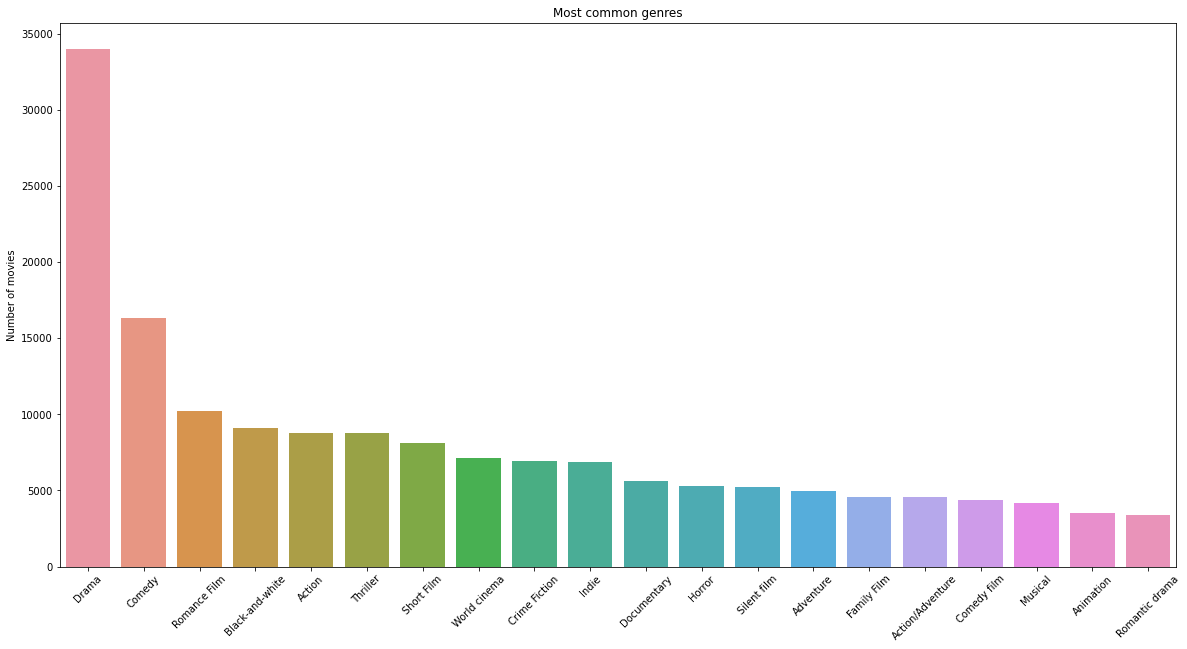

In [134]:
# visualize the most common genres
plt.figure(figsize=(20, 10))
plt.title('Most common genres')
plt.ylabel('Number of movies')
sns.barplot(x=[x for x, y in Counter([x for y in movies_metadata['Movie_genres'].values for x in y.values()]).most_common(
    20)], y=[y for x, y in Counter([x for y in movies_metadata['Movie_genres'].values for x in y.values()]).most_common(20)])
plt.xticks(rotation=45)
plt.show()


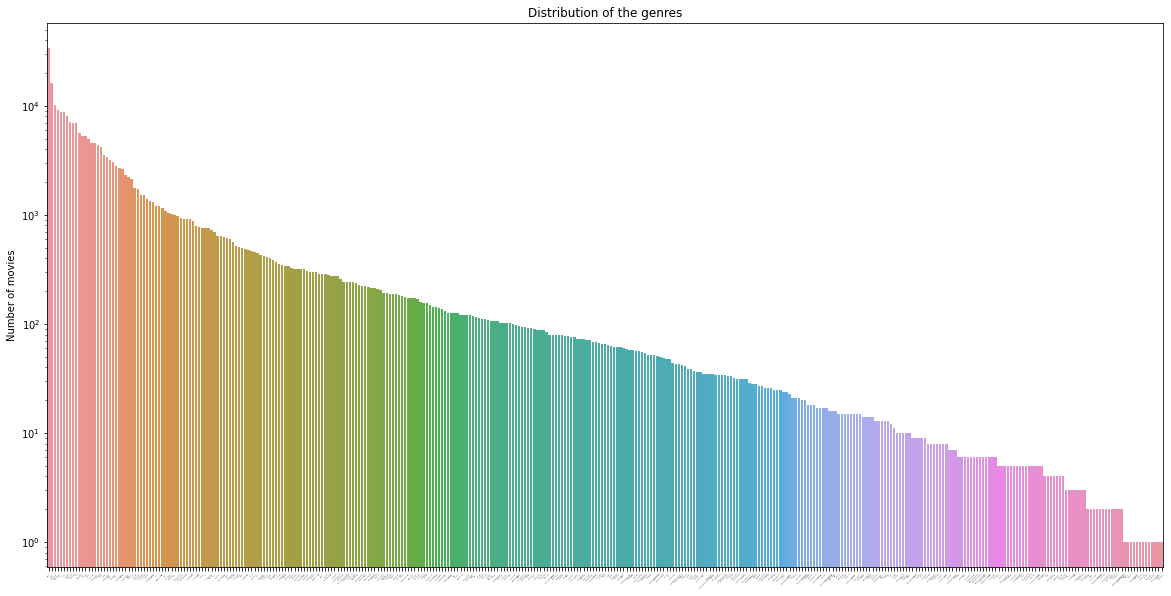

In [136]:
# visualize the distribution of the genres in log scale
plt.figure(figsize=(20, 10))
plt.title('Distribution of the genres')
plt.ylabel('Number of movies')
plt.yscale('log')
sns.barplot(x=[x for x, y in Counter([x for y in movies_metadata['Movie_genres'].values for x in y.values()]).most_common()], y=[
            y for x, y in Counter([x for y in movies_metadata['Movie_genres'].values for x in y.values()]).most_common()])
plt.xticks(rotation=45, fontsize=1)
plt.show()


We can easily notice that the genres distribution follows a power law.

### 2.2.3 character_metadata dataset: feature pre-processing

In [182]:
character_metadata


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Actor_date_of_birth,actor_gender,Actor_name,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,1958-08-26,F,Wanda De Jesus,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,1974-08-15,F,Natasha Henstridge,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,1969-06-15,M,Ice Cube,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,1967-09-12,M,Jason Statham,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,1977-09-25,F,Clea DuVall,/m/01y9xg
...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,1970-05,F,Dorothy Elias-Fahn,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,1965-04-12,M,Jonathan Fahn,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,1941-11-18,M,David Hemmings,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,Roberta Paterson,/m/0g8ngmm


#### 2.2.3.1 `Movie_release_date` column

In [7]:
# As we did with the movies metadata dataframe, we will get the year from the release date column
character_metadata['Movie_release_year'] = character_metadata['Movie_release_date'].str.split(
    '-').str[0]
# drop the release date column
character_metadata.drop(['Movie_release_date'], axis=1, inplace=True)

# show the number of missing values in the actor date of birth column
character_metadata['Actor_date_of_birth'].isnull().sum()


106145

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126]),
 [Text(0, 0, '2008'),
  Text(1, 0, '2006'),
  Text(2, 0, '2009'),
  Text(3, 0, '2007'),
  Text(4, 0, '2010'),
  Text(5, 0, '2005'),
  Text(6, 0, '2011'),
  Text(7, 0, '2004'),
  Text(8, 0, '2003'),
  Text(9, 0, '2002'),
  Text(10, 0, '2001'),
  Text(11, 0, '2000'),
  Text(12, 0, '19

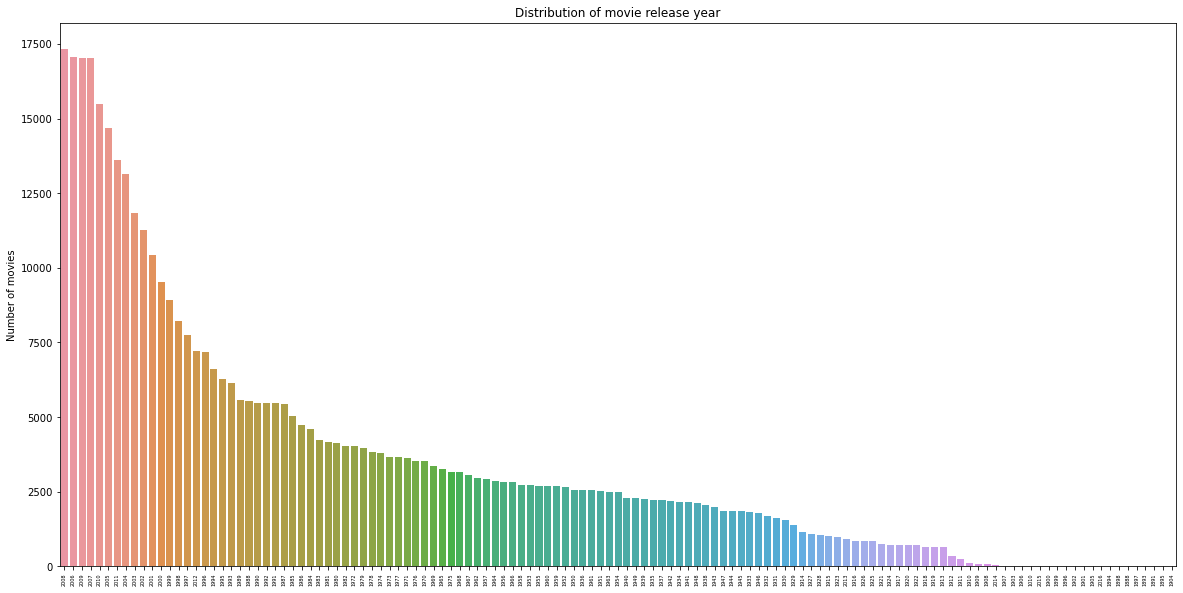

In [12]:
# visulaise the distribution of movie release year column
plt.figure(figsize=(20, 10))
plt.title('Distribution of movie release year')
plt.ylabel('Number of movies')
sns.barplot(x=[x for x, y in Counter(character_metadata['Movie_release_year'].values).most_common()], y=[
            y for x, y in Counter(character_metadata['Movie_release_year'].values).most_common()])
plt.xticks(rotation=90, fontsize=5)


#### 2.2.3.2 `Actor_date_of_birth` column

In [11]:
# As we did with the previous column, we will get the year from the actor date of birth column
character_metadata['Actor_year_of_birth'] = character_metadata['Actor_date_of_birth'].str.split(
    '-').str[0]
# drop the actor date of birth column
character_metadata.drop(['Actor_date_of_birth'], axis=1, inplace=True)
# show the number of missing values in the actor year of birth column
character_metadata['Actor_year_of_birth'].isnull().sum()


106145

#### 2.2.3.3 `Actor_name` column

We aim to create a network between actors as nodes and movies as edges. Therfore we need to match those two different dataframes. The `Wikipedia_movie_ID` and `Freebase_movie_ID` are perfect for that as they have no missing values. <br>
Furthermore we choose to use `Actor_name` as identifier for the actors as it is more understandable than the Freebase ID. As we will use it as identifier we will need to assure us that each Actor_name relates to a unique actor. And we also want to check if there is some typos in the actor names.

In [9]:
# first filter the characters where the actor name is null
character_metadata = character_metadata.dropna(subset=['Actor_name'])

# create a dataframe referencing every actor_names
actors_unique = character_metadata.drop_duplicates('Actor_name')


Let's start to see if actor names link to a unique ID. This is necessary if we want to use it as identifier. <br>
__Note:__ The following tests take a lot of times and are just there to see if somethings is wrong, once we know it we didn't need to re-run it so we commented it.

In [10]:
# # check if every same actor_names refer to same actor_id
# for a in actors_unique.Actor_name:
#     same_name = character_metadata.query("`Actor_name` == @a")
#     if same_name.Freebase_actor_ID.nunique() > 1:
#         print(a, same_name.Freebase_actor_ID.unique())


We remark that some actors have the same `Actor_name` ! 
> This mean we can't us it as an identifier as we planned but we'll need to use the Freebase ID instead.

However we would like to use the actor names and can't ignore the typo question. We tried a naive way with the `get_close_matches` function which return us similar strings. 
But we have ~100'000 different names which take a lot of time but also gives way to much matches. The problem is that we should check them by hand which isn't possible. <br>
Therefore we won't use the first method on the full dataset but later on after having created a smaller dataset we'll use.

In [11]:
# # for n in actors_unique.Actor_name:
#     if type(n) == t:
#         match = get_close_matches(n,actors_unique.Actor_name , cutoff=0.9)
#         if len(match) > 1:
#             print(match)


We thought to compare if a an id refer to more than one name. As expected it isn't the case, certainly because names and id were scrapped in the same pages.

In [12]:
# create a dataframe referencing every unique id
# actor_id_unique = character_metadata.drop_duplicates('Freebase_actor_ID')
# for i in actor_id_unique.Freebase_actor_ID:
#     same_name = character_metadata.query("`Freebase_actor_ID` == @i")
#     if same_name.Actor_name.nunique() > 1:
#         print("Freebase id: ", i, " | names: ", same_name.unique())


In [12]:
# filter characters metadata dataframe to keep only the characters where the actor name is not null
characters_before_filter = character_metadata.shape[0]
character_metadata = character_metadata[character_metadata['Freebase_actor_ID'].notnull(
)]
#character_metadata = character_metadata[character_metadata['Freebase_actor_ID'].notnull() & character_metadata['Actor_name'].notnull()]
# show how many characters were originally in the dataframe, how many were removed and how many are left
print('Number of characters before filter: ', characters_before_filter)
print('Number of characters after filter: ', character_metadata.shape[0])
print('Number of characters removed: ',
      characters_before_filter - character_metadata.shape[0])


Number of characters before filter:  450669
Number of characters after filter:  449854
Number of characters removed:  815


We need movies that have at least 2 actors to connect the nodes.

In [13]:
# list the characters of each movie in a list and the actors of each movie in a list
actors = character_metadata.groupby('Wikipedia_movie_ID')['Actor_name'].apply(
    list).reset_index().rename(columns={'Actor_name': 'Actors_names'})
# count the actors of each movie
actors['Number_of_actors'] = actors['Actors_names'].apply(lambda x: len(x))
# filter the actors dataframe to keep only the movies with more than 2 actors
actors = actors[actors['Number_of_actors'] > 2].reset_index(drop=True)
# show the number of movies before and after the filter and how many movies were removed
print('Number of movies before filter: ',
      character_metadata['Wikipedia_movie_ID'].nunique())
print('Number of movies after filter: ', actors.shape[0])
print('Number of movies removed: ',
      character_metadata['Wikipedia_movie_ID'].nunique() - actors.shape[0])


Number of movies before filter:  64308
Number of movies after filter:  48816
Number of movies removed:  15492


## 2.3 Further exploration of cleaned data

Now that we have drop the data that won't be usefull we can start analysing it.

In [15]:
# Firstly print the new dataframe merging movies and actors
actors


,Wikipedia_movie_ID,Actors_names,Number_of_actors
0,330,"[Rosa Maria Sardà, Mercè Pons, Anna Lizaran, N...",4
1,3217,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...",14
2,3333,"[Lillian Gish, Henry B. Walthall, Mae Marsh, S...",14
3,3746,"[William Sanderson, Harrison Ford, Rutger Haue...",15
4,3837,"[Jack Starrett, Slim Pickens, Dave Sharpe, Lia...",20
...,...,...,...
48765,37322106,"[Katrina Kaif, Shahrukh Khan, Anushka Sharma]",3
48766,37373877,"[Gabrielle Anwar, Traci Lords, Dina Meyer, Geo...",7
48767,37476824,"[Zayed Khan, Raveena Tandon, Amitabh Bachchan,...",10
48768,37478048,"[Anupam Kher, Anil Kapoor, Sridevi Kapoor, Akk...",4


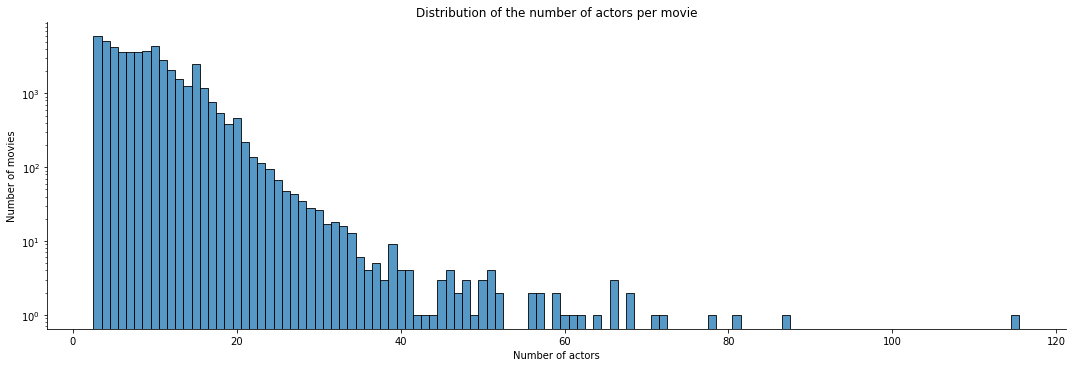

In [16]:
plot = sns.displot(actors['Wikipedia_movie_ID'], x=actors['Number_of_actors'],
                   log=True, discrete=True, aspect=3)
plot = plot.set(title='Distribution of the number of actors per movie',
                xlabel='Number of actors',
                ylabel='Number of movies')


# 3. Creating a network of actors

It's now time to creat a first network

## 3.1 Processing the data

In [17]:
# one actor per line in the new dataframe
actors_new_meta = actors.merge(character_metadata[[
                               'Character_name', 'Actor_name', 'Freebase_actor_ID', 'Wikipedia_movie_ID']], on='Wikipedia_movie_ID', how='inner')


In [18]:
actors_new_meta.sample(3)


,Wikipedia_movie_ID,Actors_names,Number_of_actors,Character_name,Actor_name,Freebase_actor_ID
170576,7529510,"[Simran Bagga, Prashanth, Nassar, Manorama, Ur...",8,Senior Advocate,Delhi Ganesh,/m/04cw5sb
90971,2836801,"[Lesley Manville, Phil Davis, Edna Doré, Phili...",10,NaN,Ruth Sheen,/m/05b4hl8
92567,2906058,"[Stephen Tobolowsky, Lorraine Toussaint, Patri...",8,NaN,Charles S. Dutton,/m/05w88j


In [19]:
# dataframe with pairs of actors and the number of movies they acted in together
# the dataframe to merge contains all the actors_new_meta dataframe except the actors_names column
to_merge = actors_new_meta.drop('Actors_names', axis=1)
actors_pairs = to_merge.merge(
    to_merge, on=['Wikipedia_movie_ID', 'Number_of_actors'], how='inner')
# filter the dataframe to keep only the pairs where the actor names are different
actors_pairs = actors_pairs[actors_pairs['Actor_name_x']
                            != actors_pairs['Actor_name_y']]
actors_pairs = actors_pairs[actors_pairs['Freebase_actor_ID_x']
                            != actors_pairs['Freebase_actor_ID_y']]
# filter the dataframe to keep only the pairs that are not interchangeable (actor1, actor2) and (actor2, actor1)
actors_pairs = actors_pairs[actors_pairs['Actor_name_x']
                            < actors_pairs['Actor_name_y']]
actors_pairs = actors_pairs[actors_pairs['Freebase_actor_ID_x']
                            < actors_pairs['Freebase_actor_ID_y']]


In [20]:
# for each pair make a new column with the list of movies they acted in together
actors_pairs_common_movies = actors_pairs.groupby(['Actor_name_x', 'Actor_name_y', 'Freebase_actor_ID_x', 'Freebase_actor_ID_y'])[
    'Wikipedia_movie_ID'].apply(list).reset_index().rename(columns={'Wikipedia_movie_ID': 'Common_movies'})
# remove the duplicates in the movies list
actors_pairs_common_movies['Common_movies'] = actors_pairs_common_movies['Common_movies'].apply(
    lambda x: list(set(x)))


In [21]:
# number of common movies between each pair of actors
actors_pairs_common_movies['Number_of_common_movies'] = actors_pairs_common_movies['Common_movies'].apply(
    lambda x: len(x))


In [22]:
# filter the dataframe to keep only the pairs that acted in more than 2 movies together
actors_pairs_common_movies_filtered = actors_pairs_common_movies[
    actors_pairs_common_movies['Number_of_common_movies'] > 2]


In [23]:
actors_pairs_common_movies_filtered.sample(3)


,Actor_name_x,Actor_name_y,Freebase_actor_ID_x,Freebase_actor_ID_y,Common_movies,Number_of_common_movies
537802,Fritz Rasp,Willy Fritsch,/m/03d1q4f,/m/0h65bk,"[7324640, 767193, 36025443]",3
98300,Anjali Devi,Vyjayanthimala,/m/03mdv9l,/m/0dm652,"[33446619, 31187940, 31385998, 31386439]",4
554828,George Brent,Geraldine Fitzgerald,/m/033htq,/m/04xq36,"[16038391, 1954198, 62111]",3


## 3.2 Creating the network

There are many ways to create networks, a really common one is the networkx library. It offers lots of tools and we can easily find documentation on the web.

In [24]:
# create a non directed graph from the dataframe
G = nx.from_pandas_edgelist(actors_pairs_common_movies_filtered, source='Freebase_actor_ID_x',
                            target='Freebase_actor_ID_y', edge_attr='Number_of_common_movies')
# show the number of nodes and edges in the graph
print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())


Number of nodes:  6320
Number of edges:  12728


Now that we have the network we'll need to analyse it. The first step is to create subgroup using the louvain algorithm.

In [25]:
# make partitions of the graph
coms = algorithms.louvain(G, weight='Number_of_common_movies')

# make subgraphs from the partitions
subgraphs = [G.subgraph(c) for c in coms.communities]
# show the number of subgraphs
print('Number of communities: ', len(subgraphs))


Number of communities:  634


In [26]:
# show the number of nodes in each subgraph and the average weight of the edges in each subgraph
for i, subgraph in enumerate(subgraphs):
    print('community ', i + 1, ' number of actors: ', subgraph.number_of_nodes())
    print('community ', i + 1, ' average numbers of movies between actors: ',
          subgraph.size(weight='Number_of_common_movies') / subgraph.number_of_edges())


community  1  number of actors:  595
community  1  average numbers of movies between actors:  4.435266084193804
community  2  number of actors:  476
community  2  average numbers of movies between actors:  3.441354292623942
community  3  number of actors:  401
community  3  average numbers of movies between actors:  3.5330948121645798
community  4  number of actors:  320
community  4  average numbers of movies between actors:  3.851111111111111
community  5  number of actors:  314
community  5  average numbers of movies between actors:  4.9286351471900085
community  6  number of actors:  241
community  6  average numbers of movies between actors:  4.173684210526316
community  7  number of actors:  224
community  7  average numbers of movies between actors:  4.872509960159363
community  8  number of actors:  199
community  8  average numbers of movies between actors:  4.0212765957446805
community  9  number of actors:  196
community  9  average numbers of movies between actors:  3.64217

community  225  number of actors:  2
community  225  average numbers of movies between actors:  3.0
community  226  number of actors:  2
community  226  average numbers of movies between actors:  4.0
community  227  number of actors:  2
community  227  average numbers of movies between actors:  5.0
community  228  number of actors:  2
community  228  average numbers of movies between actors:  3.0
community  229  number of actors:  2
community  229  average numbers of movies between actors:  13.0
community  230  number of actors:  2
community  230  average numbers of movies between actors:  3.0
community  231  number of actors:  2
community  231  average numbers of movies between actors:  4.0
community  232  number of actors:  2
community  232  average numbers of movies between actors:  3.0
community  233  number of actors:  2
community  233  average numbers of movies between actors:  3.0
community  234  number of actors:  2
community  234  average numbers of movies between actors:  3.0

community  412  average numbers of movies between actors:  3.0
community  413  number of actors:  2
community  413  average numbers of movies between actors:  3.0
community  414  number of actors:  2
community  414  average numbers of movies between actors:  3.0
community  415  number of actors:  2
community  415  average numbers of movies between actors:  3.0
community  416  number of actors:  2
community  416  average numbers of movies between actors:  8.0
community  417  number of actors:  2
community  417  average numbers of movies between actors:  3.0
community  418  number of actors:  2
community  418  average numbers of movies between actors:  3.0
community  419  number of actors:  2
community  419  average numbers of movies between actors:  3.0
community  420  number of actors:  2
community  420  average numbers of movies between actors:  4.0
community  421  number of actors:  2
community  421  average numbers of movies between actors:  4.0
community  422  number of actors:  2


community  617  average numbers of movies between actors:  4.0
community  618  number of actors:  2
community  618  average numbers of movies between actors:  4.0
community  619  number of actors:  2
community  619  average numbers of movies between actors:  3.0
community  620  number of actors:  2
community  620  average numbers of movies between actors:  3.0
community  621  number of actors:  2
community  621  average numbers of movies between actors:  3.0
community  622  number of actors:  2
community  622  average numbers of movies between actors:  5.0
community  623  number of actors:  2
community  623  average numbers of movies between actors:  3.0
community  624  number of actors:  2
community  624  average numbers of movies between actors:  3.0
community  625  number of actors:  2
community  625  average numbers of movies between actors:  3.0
community  626  number of actors:  2
community  626  average numbers of movies between actors:  3.0
community  627  number of actors:  2


## 3.3 Vizualising the network

Let's start the funny part with a basic visualization.

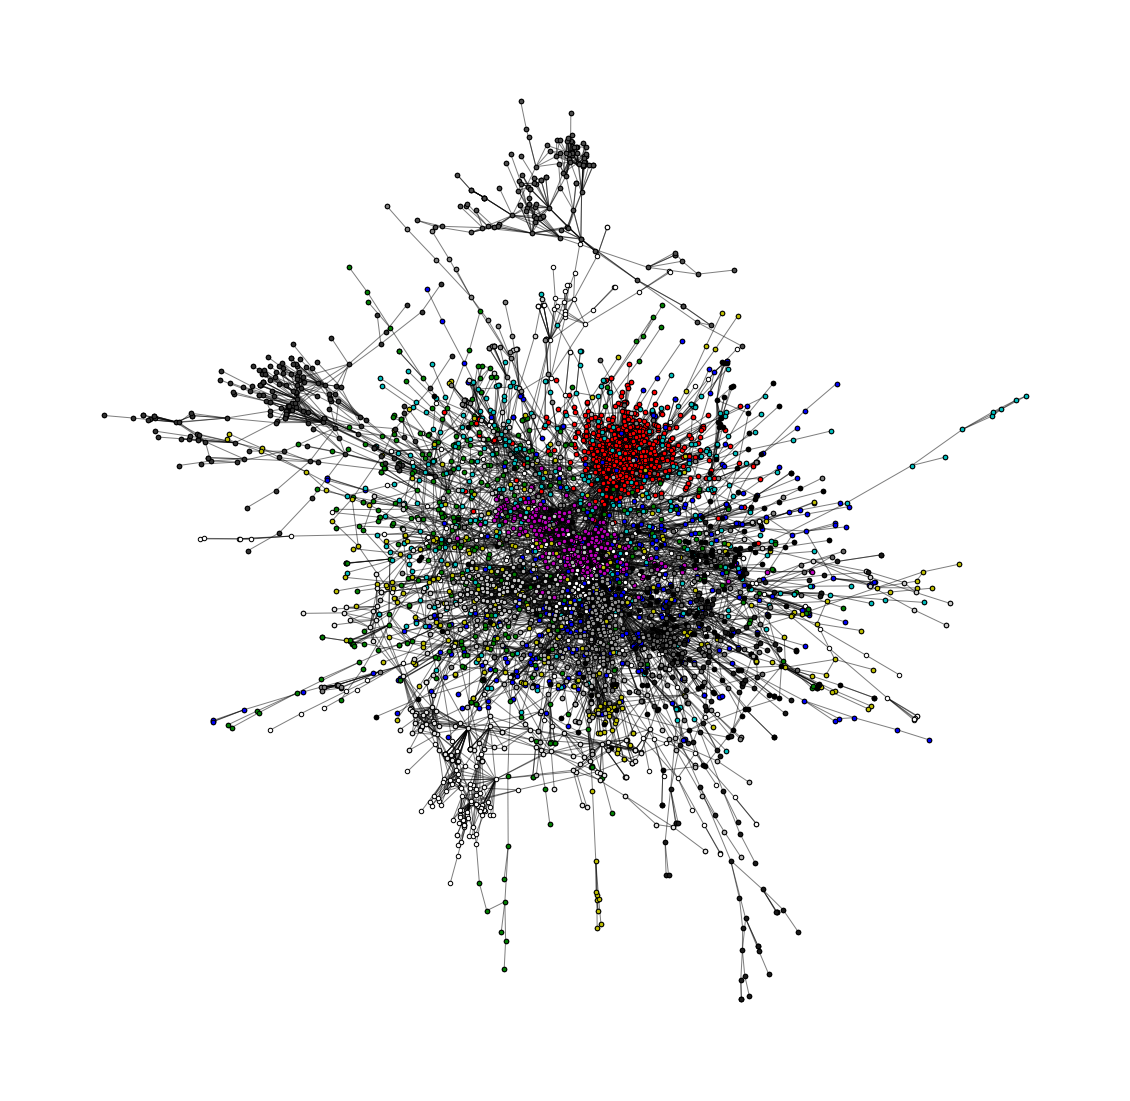

In [27]:
# vizualise the obtained partitions (top 20 communities)
viz.plot_network_clusters(G, coms, node_size=20, figsize=(
    20, 20), plot_labels=False, top_k=20)


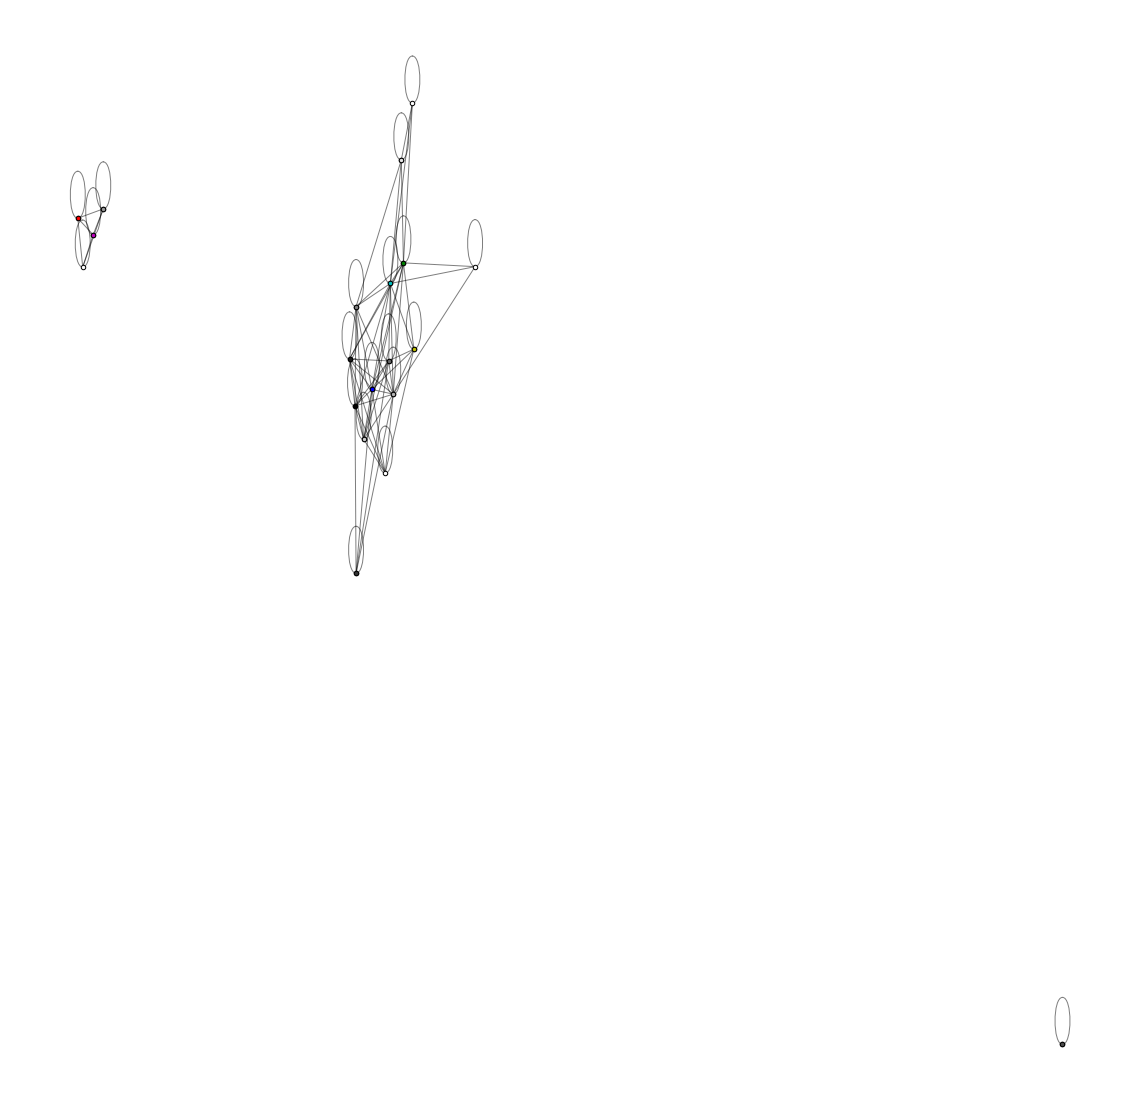

In [28]:
viz.plot_community_graph(G, coms, node_size=20, figsize=(
    20, 20), plot_labels=False, top_k=20)


In [29]:
# g = net.Network(notebook = True)
# g.from_nx(G)
# g.show("example.html")


## 3.4 Analysing subnetworks

If we aim to see tendencies between those subgroup, we'll need to add features to nodes.

In [30]:
for n in G.nodes:
    G.nodes[n]['actor_gender'] = character_metadata[character_metadata.Freebase_actor_ID ==
                                                    n]['actor_gender'].iloc[0]
    G.nodes[n]['Actor_ethnicity'] = character_metadata[character_metadata.Freebase_actor_ID ==
                                                       n]['Actor_ethnicity'].iloc[0]


We can now compute the assortativity  for certains properties. It measures the similarity of connections in the graph with respect to the given attribute.

In [31]:
print("gender assortativity: ",
      nx.attribute_assortativity_coefficient(G, 'actor_gender'))
print("ethnicity assortativity: ",
      nx.attribute_assortativity_coefficient(G, 'Actor_ethnicity'))


gender homophily:  -0.009199693354632348
ethnicity homophily:  0.20419446015283604


In [27]:
# store the top 20 communities in dataframes
# each row in the dataframe is an actor in the community, the connectivity column represents the total weight of the edges that the actor is connected to
# i.e the total number of movies the actor acted in with the other actors in the community
top_20_communities = []
for i, subgraph in enumerate(subgraphs[:20]):
    top_20_communities.append(pd.DataFrame(subgraph.degree(weight='Number_of_common_movies'), columns=[
                              'Actor_name', 'connectivity']).sort_values('connectivity', ascending=False))


In [28]:
# for each community add columns for actors ethnicity, gender and date of birth from the character_metadata dataframe
for i, community in enumerate(top_20_communities):
    top_20_communities[i] = community.merge(character_metadata[['Actor_name', 'actor_gender', 'Actor_date_of_birth',
                                            'Actor_ethnicity']], on='Actor_name', how='inner').drop_duplicates(subset=['Actor_name']).reset_index(drop=True)
    top_20_communities[i]['community'] = i + 1
top_20_communities_all_actors = pd.concat(
    top_20_communities).reset_index(drop=True)


In [29]:
G = nx.connected_watts_strogatz_graph(30, 5, .2)
nodes = G.nodes()
edges = list(G.edges(data=True))


Additionnally from observing actors in each communities, we would like to include in our communities' analysis the movies within each community, i.e. the movies that connect actors together within a single community. For this purpose, we start by mapping movies' occurencies for each community. 
Later on, we can use this table to analyze the number of movies within each community, whether a movie appears in only one, or several communities, and also add movies features such as genre, length or date of release. 

In [35]:
movies_com_list = pd.DataFrame(columns=['movie_index', 'community'])

# first we extract for each edge in a subgraph the corresponding movies and store in a dataframe the movie index and the community
for community_nb in range(1, 21):
    for x in subgraphs[community_nb].edges:
        movies = actors_pairs_common_movies_filtered.loc[(actors_pairs_common_movies_filtered['Freebase_actor_ID_x'] == x[0])
                                                         & (actors_pairs_common_movies_filtered['Freebase_actor_ID_y'] == x[1])].Common_movies
        if len(movies) == 0:
            movies = actors_pairs_common_movies_filtered.loc[(actors_pairs_common_movies_filtered['Freebase_actor_ID_x'] == x[1])
                                                             & (actors_pairs_common_movies_filtered['Freebase_actor_ID_y'] == x[0])].Common_movies
        if len(movies) == 0:
            print('error')
        for liste in movies:
            for elt in liste:
                movies_com_list = movies_com_list.append(pd.DataFrame([[int(elt), int(
                    community_nb)]], columns=['movie_index', 'community']), ignore_index=True)

# data rearranged to have each movie as a row, and each community as a column. the value describes the numbers of edges referring to a movie within the specified community
movie_com_table = movies_com_list.pivot_table(
    columns='community', index='movie_index', aggfunc=len, fill_value=0)
movie_com_table.to_csv('movies_communities_table.csv')


In [36]:
movie_com_table


community,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
movie_index,,,,,,,,,,,,,,,,,,,,
3333,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3837,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0
4231,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4726,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4728,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36427339,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
36460235,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
36474734,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# Aggregate this information with the features of each movie
movies_com_metadata = pd.merge(
    movies_metadata, movie_com_table, left_on='Wikipedia_movie_ID', right_on='movie_index')
movies_com_metadata.to_csv('movies_communities_metadata.csv')
# we still need to clean the Movie_languages, Movie_countries and Movie_genre ?


## 3.5 Preprocessing of scraped data ( example on an older network of communities )

The dataframe used in this section is the dataframe produced by the file "scraping.ipynb" . 
This dataframe is based on an older and no longer valid version of our top 20 communities . 
<br /> The scraping was done only on the cast of actors of those communities for time constraints but our network have changed in the meantime. So this is just an example of how we would preprocess the data obtained from scraping ,  namely "actor_country_of_citizenship" and "actor_occupation".

In [3]:
# load actor dataframe after scraping
actors_scraping = pd.read_csv(
    'CSV_files/top_20_communities_all_actors_wikidata_with_country_occupation.csv')
actors_scraping.sample(3)


,Actor_name,connectivity,actor_gender,Actor_date_of_birth,Actor_ethnicity,Freebase_actor_ID,community,Wikidata_actor_id,actor_country_of_citizenship,actor_occupation
3296,Daniel Day-Lewis,3,M,4/29/1957,/m/041rx,/m/016yvw,5,Q166389,Republic of Ireland,"['film actor', 'artist', 'stage actor', 'telev..."
4711,Ian McNeice,6,M,10/2/1950,NaN,/m/08_438,10,Q1655608,United Kingdom,"['actor', 'film actor', 'stage actor', 'televi..."
5567,Edgar Dearing,15,M,1893-05-04,NaN,/m/026v4xp,15,Q5337205,United States of America,"['actor', 'television actor']"


### Country of citizenship cleaning 

In [4]:
# extract unique country names
unique_countries = actors_scraping['actor_country_of_citizenship'].unique()
unique_countries


array(['United States of America', 'United Kingdom', nan, 'Canada',
       'Hungary', 'Mexico', 'Republic of Ireland', 'France',
       'Soviet Union', 'Sweden', 'Romania', 'Kingdom of Romania',
       'United Kingdom of Great Britain and Ireland', 'Portugal',
       'Belgium', 'Dominican Republic', 'Scotland', 'Kingdom of Hungary',
       'Russian Empire', 'Australia', 'Russia', 'Austria', 'Japan',
       'Spain', 'Germany', 'Ottoman Empire', 'Croatia', 'Greece', 'Malta',
       'German Empire', 'Italy', 'Switzerland',
       'Kingdom of the Netherlands', 'Poland', 'England', 'Dominica',
       'New Zealand', 'India', 'British Raj', 'Pakistan', 'Nepal',
       'Sri Lanka', 'Norway', 'Honduras', 'Puerto Rico', 'Philippines',
       'South Africa', 'Wales', 'Egypt', "People's Republic of China",
       'Argentina', 'Colombia', 'Lithuania', 'Armenia', 'Cuba',
       'Venezuela', 'Brazil', 'Panama', 'Nigeria', 'Bhutan', 'Denmark',
       'British Hong Kong', 'Hong Kong', 'Taiwan', 'Singap

We can see that we have some countries that are named in more than way ; Hungary / Kingdom of Hungary , United Kingdom of Great Britain / England / United Kingdom , Russia / Soviet Union ... <br /> We tried to use again a sequence matcher but it didn't hold much results , we will have to regroup manually the concerned countires. <br /> Old country names such as "Ottoman Empire","Soviet Union","British Raj" have been renamed to their modern names

In [5]:
# function that outputs a similarity score between strings
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()


In [6]:
# apply the similarity function on unique country names obtained
matches = []
for n in unique_countries:
    for x in unique_countries:
        if n != x:
            match = similar(str(n), str(x))
            if match > 0.5:
                matches.append(['match score =', "%.2f" %
                               match, str(n)+' / '+str(x)])
matches[2:10]


[['match score =', '0.67', 'Canada / Panama'],
 ['match score =', '0.56', 'Hungary / Kingdom of Hungary'],
 ['match score =', '0.58', "Republic of Ireland / People's Republic of China"],
 ['match score =', '0.72', 'Republic of Ireland / Republic of China'],
 ['match score =', '0.60', 'Soviet Union / Slovenia'],
 ['match score =', '0.56', 'Romania / Kingdom of Romania'],
 ['match score =', '0.57', 'Romania / Croatia'],
 ['match score =', '0.67', 'Romania / Dominica']]

In [7]:
# Merge concerned countries into unique key countries
countries_wordsets = dict([
    ('United Kingdom', [
     'United Kingdom of Great Britain and Ireland', 'Scotland', 'England', 'Wales']),
    ('Ireland', ['Republic of Ireland']),
    ('Russia', ['Soviet Union', 'Russian Empire']),
    ('Romania', ['Kingdom of Romania']),
    ('Hungary', ['Kingdom of Hungary']),
    ('China', ['Republic of China', 'People\'s Republic of China']),
    ('Italy', ['Kingdom of Italy']),
    ('Hong Kong', ['British Hong Kong']),
    ('India', ['British Raj']),
    ('Germany', ['German Empire']),
    ('Turkey', ['Ottoman Empire'])
])


Now that we have a dictionary that can normalize country names , all we have to do is replace the problematic country names with their correspondant name .

In [8]:
actors_scraping['actor_country_of_citizenship'] = actors_scraping['actor_country_of_citizenship'].apply(
    lambda x:  [k for k, v in countries_wordsets.items() if x in v][0] if len([k for k, v in countries_wordsets.items() if x in v]) != 0 else x)
actors_scraping['actor_country_of_citizenship'].value_counts()


United States of America      2798
India                         1157
United Kingdom                 740
Japan                          233
China                          137
Canada                         131
France                         117
Italy                           65
Australia                       57
Ireland                         49
Hong Kong                       42
Spain                           28
Germany                         27
New Zealand                     24
Taiwan                          23
Mexico                          15
Egypt                           12
Sweden                          11
Austria                          9
Portugal                         9
Puerto Rico                      7
Russia                           6
Hungary                          5
Belgium                          5
South Africa                     4
South Korea                      4
Pakistan                         4
Kingdom of the Netherlands       4
Switzerland         

### Occupation preprocessing

The occupation column is a list of occupations in string format . 
<br /> The first step is to eliminate non desired characters from the string such as ' , [ , ] 

In [9]:
# extract a list from actor_occupations column
list_occupations = list(actors_scraping['actor_occupation'])
# function that extracts occupations from string of occupations


def extract_occupation(string):
    occupation_list = ""
    if isinstance(string, str):
        string = string.replace("'", "")
        string = string.replace("[", "")
        string = string.replace("]", "")
        occupation_list = string.split(",")

    return occupation_list


occupations_with_dupilicate = []
# get a list of all occupations with duplicates
for s in list_occupations:
    split_string = extract_occupation(s)
    split_string = [x.strip() for x in split_string]
    occupations_with_dupilicate.append(split_string)


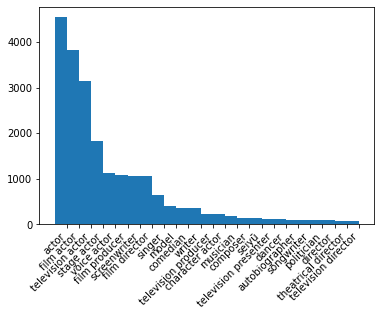

In [10]:
# get a list of unique occupations
occupations_unique = Counter(
    [item for sublist in occupations_with_dupilicate for item in sublist])
top_25_occupations = occupations_unique.most_common(25)

labels = [i[0] for i in top_25_occupations]
values = [i[1] for i in top_25_occupations]
indexes = np.arange(len(top_25_occupations))
width = 1
# plot histogram of top 25 occupations distribution
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.xticks(rotation=45, ha='right')
plt.show()


We can observe here the 25 most common occupations . <br /> We can see that for the "actor" occupation for example, there are a lot of variations like "film actor" , "stage actor" ... <br />These differences will induce non desired variance between actor occupation , for this reason , we aim here to regroup the different occupation into key occupations that would better represent specific communities . <br /> To be sure to take into account most relevant occupations , we are going to consider the top 50 occupations present in our communities and label them and replace all remaining occupations with "other"

In [11]:
# get a list of unique occupations
occupations_unique.most_common(50)


[('actor', 4544),
 ('film actor', 3827),
 ('television actor', 3148),
 ('stage actor', 1827),
 ('voice actor', 1137),
 ('film producer', 1074),
 ('screenwriter', 1059),
 ('film director', 1052),
 ('singer', 654),
 ('model', 401),
 ('comedian', 362),
 ('writer', 349),
 ('television producer', 237),
 ('character actor', 225),
 ('musician', 182),
 ('composer', 131),
 ('seiyū', 130),
 ('television presenter', 118),
 ('dancer', 109),
 ('autobiographer', 103),
 ('songwriter', 93),
 ('politician', 88),
 ('director', 86),
 ('theatrical director', 81),
 ('television director', 78),
 ('recording artist', 70),
 ('dub actor', 68),
 ('singer-songwriter', 68),
 ('manufacturer', 62),
 ('radio personality', 60),
 ('stunt performer', 48),
 ('film editor', 48),
 ('playwright', 47),
 ('beauty pageant contestant', 45),
 ('journalist', 44),
 ('businessperson', 42),
 ('stand-up comedian', 37),
 ('guitarist', 37),
 ('author', 36),
 ('novelist', 34),
 ('rapper', 34),
 ('painter', 33),
 ('executive producer', 

In [12]:
# Merge top 50 occupations into unique key occupations
occupation_wordsets = dict([
    ('actor', ['actor', 'film actor',
     'television actor', 'stage actor', 'child actor']),
    ('voice actor', ['voice actor', 'dub actor']),
    ('director', ['director', 'film director',
     'theatrical director', 'television director']),
    ('musician', ['singer', 'musician', 'yodeler', 'songwriter', 'rapper',
                  "guitarist", "recording artist", "record producer", "singer-songwriter", 'jazz musician', 'im', 'ive']),
    ('producer', ['producer', 'film producer', 'television producer', 'film editor', 'rapper',
                  "guitarist"]),
    ('writer', ['screenwriter', 'novelist', 'author', 'playwright', 'writer',
                "autobiographer"]),
    ('dancer', ['dancer', 'ballet dancer']),
    ('model', ['model', 'beauty pageant contestant']),
    ('athlete', ['American football player', 'stunt performer', 'athlete']),
    ('presenter', ['radio personality', 'presenter']),
    ('artist', ['painter', 'sculptor', 'poet', 'painter']),
    ('politician', ['military officer', 'military personnel', 'politician']),
    ('comedian', ['comedian', 'stand-up comedian', 'podcaster']),
    ('businessperson', ['businessman', 'businesswoman',
     'businessperson', 'entrepreneur']),
    ('journalist', ['journalist'])
])


Now that we have a clear classification of the occupations we can find in the dataset , all we have to do is replace any non

First initial analysis

In [14]:
df_feature_distribution = pd.DataFrame(columns=['Community', 'Males', 'Females', '1st_country',
                                       '2nd_country', '3rd_country', '1st_occupation', '2nd_occupation', '3rd_occupation'])
for i in range(1, 20):
    df = actors_scraping[actors_scraping['community'] == i]
    gender_distribution = df['actor_gender'].value_counts(normalize=True) * 100
    country_distribution = df['actor_country_of_citizenship'].value_counts(
        normalize=True)
    occupation_distribution = df['actor_occupation'].value_counts(
        normalize=True)
    print("Community", i, ":")
    print("Males=", gender_distribution.M, "%,Females=", gender_distribution.F)
    print(country_distribution[:3].to_string())
#     print(occupation_distribution[:3].to_string())


Community 1 :
Males= 67.68916155419224 %,Females= 32.31083844580777
United States of America    0.801036
United Kingdom              0.097409
Canada                      0.033161
Community 2 :
Males= 59.33147632311978 %,Females= 40.66852367688023
India             0.969256
United Kingdom    0.012945
Pakistan          0.004854
Community 3 :
Males= 67.31107205623901 %,Females= 32.68892794376098
United States of America    0.900722
Canada                      0.041516
United Kingdom              0.032491
Community 4 :
Males= 71.90812720848056 %,Females= 28.091872791519435
United Kingdom              0.616756
United States of America    0.169340
Australia                   0.074866
Community 5 :
Males= 71.30434782608695 %,Females= 28.695652173913043
United States of America    0.761062
United Kingdom              0.059735
Canada                      0.042035
Community 6 :
Males= 66.01671309192201 %,Females= 33.98328690807799
India     0.987915
Egypt     0.003021
Bhutan    0.003021
Communit

In [13]:
# df = top_20_communities_all_actors.groupby('community')

# df_fill = df.agg('count')
# # df_fill[['connectivity','actor_gender','Actor_date_of_birth','Actor_ethnicity']]/4
# df_fill['actor_gender'] = df_fill.apply(
#     lambda r: r.actor_gender/r.Actor_name*100, axis=1)
# df_fill['connectivity'] = df_fill.apply(
#     lambda r: r.connectivity / r.Actor_name*100, axis=1)
# df_fill['Actor_date_of_birth'] = df_fill.apply(
#     lambda r: r.Actor_date_of_birth/r.Actor_name*100, axis=1)
# df_fill['Actor_ethnicity'] = df_fill.apply(
#     lambda r: r.Actor_ethnicity/r.Actor_name*100, axis=1)
# df_fill

# # gender is always here
# # date of birth never less than 70%
# # ethnicity very small representation (no more than 60% values)
